In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import swifter
from sklearn.model_selection import train_test_split
import re
import nltk
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import tensorflow as tf

## Word2Vec with CNN
Each word will tranform by pretrained model to vector in size 300 so each instance is atually a matrix

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import swifter
from sklearn.model_selection import train_test_split
import re
import nltk
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import tensorflow as tfa

In [3]:
NUM_WORKERS = 8
TEST_SIZE = 0.3
LABEL_COLUMN_NAME = "oh_label"
TEXT_COLUMN_NAME = "Text"
DATASET_PATH = "../Data/ver1.csv"

In [4]:
df= pd.read_csv(DATASET_PATH, index_col=False)
df = df.dropna()
df.drop(["Unnamed: 0", "index"],axis=1, inplace = True)

In [9]:
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [10]:
import gensim.downloader
#glove-twitter-200
glove_vectors = gensim.downloader.load('glove-twitter-200')

In [7]:
df[TEXT_COLUMN_NAME].swifter.apply(lambda text: len(nltk.word_tokenize(text))).describe()

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

count    100000.000000
mean         74.415120
std         146.039735
min           0.000000
25%          18.000000
50%          34.000000
75%          76.000000
max        9851.000000
Name: Text, dtype: float64

In [8]:
import swifter
import re
import nltk
import string

MAX_NUMBER_OF_WORDS = 75
ENCODE_SIZE = 200
def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct

def get_vector(word):
    try:
        return glove_vectors.get_vector(word)
    except Exception as e:
#         print(e)
        pass
    return np.zeros((ENCODE_SIZE,))

def precoess_row(text):
    text = remove_punct(re.sub(r'\d+', 'number', text))
    vec = np.array([get_vector(word.lower()) for word in nltk.word_tokenize(text)])
    if vec.shape[0] == 0:
        return np.nan
    if vec.shape[0] >= MAX_NUMBER_OF_WORDS:
        vec = vec[:MAX_NUMBER_OF_WORDS,:]
    else:
        vec = np.vstack((vec,np.zeros((MAX_NUMBER_OF_WORDS-vec.shape[0],ENCODE_SIZE))))
    return vec

In [9]:
df[TEXT_COLUMN_NAME] = df[TEXT_COLUMN_NAME].swifter.apply(precoess_row)

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

In [10]:
lst = []
ignored = []
for i,a in enumerate(df[TEXT_COLUMN_NAME]):
    try:
        if a.shape == (MAX_NUMBER_OF_WORDS,ENCODE_SIZE):
            lst.append(a)
    except:
        ignored.append(i)
df = df.drop(ignored)

In [11]:
X = np.stack(lst)
y = df[LABEL_COLUMN_NAME]

In [13]:
X.shape,y.shape

((99988, 75, 200), (99988,))

In [12]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

{0: 0.26774212905548667, 1: 0.7322578709445133}


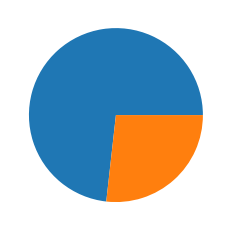

In [20]:
plt.pie(y.value_counts())
x_neg_weight = y[y==1].shape
x_pos_weight = y[y==0].shape
x_neg_weight[0]/x_pos_weight[0]
weights = {0: (x_neg_weight[0]/(x_pos_weight[0]+x_neg_weight[0])),1: (x_pos_weight[0]/(x_pos_weight[0]+x_neg_weight[0]))}
print(weights)

In [27]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,MaxPool1D,Flatten,Conv2D,Dropout,MaxPooling2D
model = Sequential()
model.add(Conv2D(5,(3,3), use_bias=True,padding="valid",input_shape=(MAX_NUMBER_OF_WORDS,ENCODE_SIZE,1)))
model.add(MaxPooling2D(pool_size=(3,3),padding='valid'))
model.add(Conv2D(10,(3,3), use_bias=True,padding="valid"))
model.add(MaxPooling2D(pool_size=(5,5),padding='valid'))
model.add(Flatten())
model.add(Dense(250, activation="relu"))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=["accuracy",tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 73, 198, 5)        50        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 24, 66, 5)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 22, 64, 10)        460       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 12, 10)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 480)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 250)               120250    
_________________________________________________________________
dropout_13 (Dropout)         (None, 250)              

In [40]:
np.expand_dims(x_train,axis=-1).shape,y_train.shape

((74991, 50, 50, 1), (74991,))

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
history = model.fit(np.expand_dims(x_train,axis=-1),y_train,batch_size=200,epochs=2000,
                    validation_split=0.05,class_weight=weights,
                    use_multiprocessing=True,workers=NUM_WORKERS,callbacks=[callback])

Epoch 1/2000
380/380 [==============================] - 134s 351ms/step - loss: 0.2718 - accuracy: 0.3841 - recall_5: 0.7505 - precision_5: 0.2680 - val_loss: 0.6916 - val_accuracy: 0.7370 - val_recall_5: 0.0000e+00 - val_precision_5: 0.0000e+00
Epoch 2/2000
380/380 [==============================] - 136s 357ms/step - loss: 0.2718 - accuracy: 0.6215 - recall_5: 0.2306 - precision_5: 0.2637 - val_loss: 0.6929 - val_accuracy: 0.7370 - val_recall_5: 0.0000e+00 - val_precision_5: 0.0000e+00
Epoch 3/2000
380/380 [==============================] - 133s 351ms/step - loss: 0.2718 - accuracy: 0.5150 - recall_5: 0.4594 - precision_5: 0.2656 - val_loss: 0.6930 - val_accuracy: 0.7370 - val_recall_5: 0.0000e+00 - val_precision_5: 0.0000e+00
Epoch 4/2000
380/380 [==============================] - 128s 337ms/step - loss: 0.2718 - accuracy: 0.4749 - recall_5: 0.5415 - precision_5: 0.2650 - val_loss: 0.6934 - val_accuracy: 0.2630 - val_recall_5: 1.0000 - val_precision_5: 0.2630
Epoch 5/2000
380/380 [==

In [22]:
model.save("cnn_glove3")

INFO:tensorflow:Assets written to: cnn_glove3\assets


In [23]:
from sklearn.metrics import classification_report
pred = model.predict(np.expand_dims(x_test,axis=-1)).flatten()
pred[pred < 0.5] = 0
pred[pred > 0.5] = 1
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

         0.0       0.73      1.00      0.85     14631
         1.0       0.00      0.00      0.00      5367

    accuracy                           0.73     19998
   macro avg       0.37      0.50      0.42     19998
weighted avg       0.54      0.73      0.62     19998



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Train Metrics')
plt.ylabel('Metric')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

KeyError: 'acc'

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

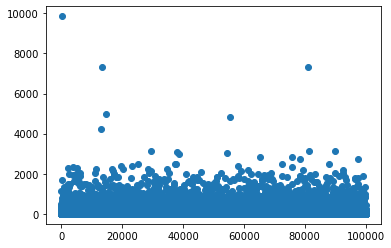

In [62]:
plt.scatter(list(range(df.shape[0])),df["Text"].swifter.apply(lambda text: len(nltk.word_tokenize(text))).values)

In [58]:
model = Sequential()
model.add(Bidirectional(LSTM(48,recurrent_dropout=0.5),input_shape=(200,1)))
model.add(Dense(24, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer='adam',metrics=["accuracy"])
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 96)                19200     
_________________________________________________________________
dense_37 (Dense)             (None, 24)                2328      
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 25        
Total params: 21,553
Trainable params: 21,553
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
history = model.fit(x_train.squeeze(),y_train,batch_size=200,epochs=100,
                    validation_split=0.05,class_weight=weights.to_dict(),
                    use_multiprocessing=True,workers=NUM_WORKERS,callbacks=[callback])